# Analyzing Assessed Value of the Downtown Mall

# Step 1: Aquire Data

# Step 2: Prepare Data

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import requests
import folium

%matplotlib inline

## Import .xls retrieved from the GIS Viewer into pandas

In [2]:
#Path to the .xls retrieve from the GIS Viewer
f = r'./data/mall_parcels_no_ends.xls'
#Create a dataframe that reads the .xls file
df = pd.read_excel(f)
#Identify all rows in df where MULTIPIN column is not equal to 1
not_multipin = df['MULTIPIN'] != 1
#Create a new dataframe that only contains the rows identified in not_multipin
df = df[not_multipin]

## Access geojson data for parcel area boundaries

In [3]:
formatted_gpins = [str(x) for x in df['GPIN'].unique()]
formatted_gpins = formatted_gpins
formatted_gpins = ','.join(formatted_gpins)

#Query url
parcel_url = f'https://opendata.arcgis.com/datasets/320d465ddf0d498796da6491e21f6dde_43.geojson?where=GPIN%20in%20({formatted_gpins})'
parcel_request = requests.get(parcel_url)
parcel_json = parcel_request.json()

## Access json annual assessment data

In [4]:
formatted_pins = [f'%27{x}%27' for x in df['PIN'].unique()]
formatted_pins_1 = formatted_pins
formatted_pins_1 = ','.join(formatted_pins_1)

assessment_url = f"https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_2/MapServer/2/query?where=UPPER(ParcelNumber)%20in%20({formatted_pins_1})%20&outFields=ParcelNumber,LandValue,ImprovementValue,TotalValue,TaxYear&outSR=4326&f=json"

assessment_request = requests.get(assessment_url)

d1 = assessment_request.json()

In [5]:
# Create data series based on features and combine data frames into a single df
df1 = pd.DataFrame(d1['features'])
# Create a single data frame based on combined series data
assessments = pd.DataFrame([x for x in df1['attributes']], dtype = 'object')
assessments = assessments.astype({'TaxYear': 'int64', 'ImprovementValue': 'int64','LandValue': 'int64','TotalValue': 'int64', 'ParcelNumber': 'str'})

## Create data frame from df that holds PIN and GPIN. Will be used to joined assessments, so that parcel area can be joined with assessments

In [6]:
df_key = pd.DataFrame(df[['PIN','GPIN']], dtype = 'str')

In [7]:
d = pd.merge(assessments, df_key, how='inner', left_on=['ParcelNumber'], right_on=['PIN'])

In [8]:
#Create data frame of assessed values for all parcels by specified year
year_min = int(d['TaxYear'].min())
year_max = int(d['TaxYear'].max())
years = (x for x in range(year_min, year_max+1))
#total_val_col = d['TotalValue'][d['TaxYear'] == 2019].mean()
assessment_chart_list = []
for x in years:
    year_col = x
    land_col_mean = d['LandValue'][d['TaxYear'] == x].mean()
    imp_col_mean = d['ImprovementValue'][d['TaxYear'] == x].mean()
    total_col_mean = d['TotalValue'][d['TaxYear'] == x].mean()
    
    land_col_min = d['LandValue'][d['TaxYear'] == x].min()
    imp_col_min = d['ImprovementValue'][d['TaxYear'] == x].min()
    total_col_min = d['TotalValue'][d['TaxYear'] == x].min()
    
    land_col_max = d['LandValue'][d['TaxYear'] == x].max()
    imp_col_max = d['ImprovementValue'][d['TaxYear'] == x].max()
    total_col_max = d['TotalValue'][d['TaxYear'] == x].max()
    
    assessment_chart_list.append(
        [year_col, land_col_mean, imp_col_mean, total_col_mean, land_col_min, imp_col_min, 
         total_col_min, land_col_max, imp_col_max, total_col_max])
assessment_chart_cols = ['Tax Year', 'Mean Land Value', 'Mean Improvement Value', 'Mean Total Value',
    'Min Land Value', 'Min Improvement Value', 'Min Total Value', 'Max Land Value', 'Max Improvement Value', 
    'Max Total Value']
assessment_chart_df = pd.DataFrame(assessment_chart_list, columns = assessment_chart_cols)

In [9]:
#Combine geojson and json data
a = pd.read_json(parcel_url)
b = a['features']
c = (x for x in b)
ft_list = []
for x in c:
    ft_list.append([x['properties']['GPIN'],x['geometry']['coordinates']])
geojson_df = pd.DataFrame(ft_list, columns = ['GPIN','coordinates'])
geojson_df['GPIN_str'] = pd.DataFrame(geojson_df['GPIN'], dtype = 'str')
temp_df = d[['GPIN','TotalValue']]
print([[x,len(x),type(x)] for x in temp_df['GPIN'].head(10)])
print('\n')
print([[x,len(x),type(x)] for x in geojson_df['GPIN_str'].head(10)])
#print(temp_df.dtypes, geojson_df.dtypes)
z = temp_df.merge(geojson_df, left_on = 'GPIN', right_on = 'GPIN_str')
z

[['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>], ['6861', 4, <class 'str'>]]


[['6493', 4, <class 'str'>], ['6537', 4, <class 'str'>], ['6569', 4, <class 'str'>], ['6604', 4, <class 'str'>], ['6625', 4, <class 'str'>], ['6633', 4, <class 'str'>], ['6644', 4, <class 'str'>], ['6655', 4, <class 'str'>], ['6656', 4, <class 'str'>], ['6662', 4, <class 'str'>]]


,GPIN_x,TotalValue,GPIN_y,coordinates,GPIN_str
0,6861,5963500,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
1,6861,5721100,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
2,6861,5795845,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
3,6861,4000500,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
4,6861,3795600,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
5,6861,3795600,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
6,6861,3609300,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
7,6861,3609300,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
8,6861,4104500,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861
9,6861,6547000,6861,"[[[-78.48280641299056, 38.03075462954861], [-7...",6861


# Step 3: Analyze

In [10]:
def total_value_by_year(year):
    tv_df = d[['GPIN','TotalValue']][d['TaxYear'] == year]
    tv_df = tv_df.astype({'GPIN': 'int', 'TotalValue': 'int'})
    return tv_df

# Step 4: Report

## Plot Values over time

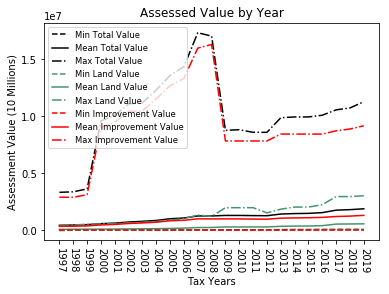

In [11]:
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Total Value'], linestyle = '--', color = '#000000', label='Min Total Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Total Value'], linestyle = '-', color = '#000000', label='Mean Total Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Total Value'], linestyle = '-.', color = '#000000', label='Max Total Value')

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Land Value'], linestyle = '--', color = '#41966d',  label='Min Land Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Land Value'], linestyle = '-', color = '#41966d', label='Mean Land Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Land Value'],  linestyle = '-.', color = '#41966d', label='Max Land Value')

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Improvement Value'], linestyle = '--', color = '#ff0000', label='Min Improvement Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Improvement Value'], linestyle = '-', color = '#ff0000', label='Mean Improvement Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Improvement Value'], linestyle = '-.', color = '#ff0000', label='Max Improvement Value')

plt.title('Assessed Value by Year')
plt.xlabel('Tax Years')
plt.ylabel('Assessment Value (10 Millions)')

plt.xticks(range(assessment_chart_df['Tax Year'].min(), assessment_chart_df['Tax Year'].max()+1), rotation=270)
plt.yticks(range(0, int(assessment_chart_df['Max Total Value'].max()), 5000000))

plt.legend(fontsize = 'small')
plt.savefig('plot.png', dpi=300, edgecolor = 'w', orientation='landscape')

## Map assessed value by year

In [12]:
def choropleth_assessed_val_by_year(year):
    m = folium.Map(location=[38.03090, -78.48044], zoom_start=17, tiles='OpenStreetMap')
    folium.Choropleth(
        geo_data = parcel_url,
        data=total_value_by_year(year),
        columns=['GPIN', 'TotalValue'], 
        key_on='feature.properties.GPIN', 
        bins=[0, 250000, 500000, 1000000, 2000000, 5000000, 10000000, 16000000],
        fill_color= 'YlOrRd',
        nan_fill_color='black', 
        fill_opacity=0.9, 
        nan_fill_opacity=1, 
        line_color='black', 
        line_weight=1, 
        line_opacity=1, 
        name='Assessed Value',
        legend_name= f'Total Assessed Value {year}'
    ).add_to(m)
    return(m)

choropleth_assessed_val_by_year(2019)

# Use this to create a new geojson dataset for map application

In [13]:
#https://gis.stackexchange.com/questions/220997/pandas-to-geojson-multiples-points-features-with-python
import pandas as pd
import geojson

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["long"],
                                                    X["lat"],
                                                    X["elev"])),
                            properties=dict(name=X["name"],
                                            description=X["description"])))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

col = ['lat','long','elev','name','description']
data = [[-29.9953,-70.5867,760,'A','Place ñ'],
        [-30.1217,-70.4933,1250,'B','Place b'],
        [-30.0953,-70.5008,1185,'C','Place c']]

df = pd.DataFrame(data, columns=col)

data2geojson(df)

ModuleNotFoundError: No module named 'geojson'